## Dogs vs Cats

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

The dataset is available at http://files.fast.ai/data/dogscats.zip. You can download it directly on your server by running the following line in your terminal. wget http://files.fast.ai/data/dogscats.zip. You should put the data in a subdirectory of this notebook's directory, called data/. Note that this data is already available in Crestle and the Paperspace fast.ai template.

In [4]:
PATH = "data/dogscats/"
sz=224

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

## First look at cat pictures

In [9]:
os.listdir(PATH)

['valid', 'models', 'test1', 'sample', 'train']

In [10]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [11]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.1819.jpg',
 'cat.9561.jpg',
 'cat.9861.jpg',
 'cat.2190.jpg',
 'cat.7991.jpg']

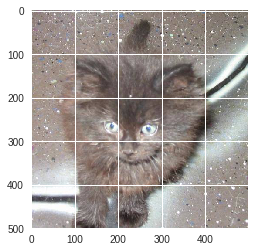

In [12]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

Here is how the raw data looks like

In [13]:
img.shape

(500, 498, 3)

In [14]:
img[:4,:4]

array([[[152, 142, 130],
        [132, 124, 111],
        [158, 152, 138],
        [201, 197, 185]],

       [[150, 140, 128],
        [136, 126, 114],
        [138, 130, 117],
        [149, 145, 133]],

       [[156, 146, 134],
        [144, 134, 122],
        [138, 130, 117],
        [135, 129, 117]],

       [[152, 140, 128],
        [141, 131, 121],
        [148, 138, 128],
        [154, 146, 135]]], dtype=uint8)

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [ ]:
# This is the label for a val data
data.val_y

In [ ]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

In [ ]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

In [ ]:
log_preds[:10]

In [ ]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [ ]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [ ]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [ ]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [ ]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [ ]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [ ]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

In [ ]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [ ]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Improving our model

### Data augmentation

In [7]:
# Uncomment the below if you need to reset your precomputed activations
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [8]:
arch=resnet34

In [9]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [10]:
%%time
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 85004554.84it/s]


100%|██████████| 32/32 [00:15<00:00,  2.08it/s]


In [16]:
learn.lr_find()

 86%|████████▋ | 311/360 [00:07<00:01, 43.27it/s, loss=0.71] 


In [17]:
learn.sched.plot_lr()

In [18]:
learn.sched.plot()

In [19]:
%%time
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.061284   0.028036   0.9905    

CPU times: user 5.73 s, sys: 6.29 s, total: 12 s
Wall time: 8.98 s


[array([0.02804]), 0.9905]

In [20]:
learn.precompute=False

In [21]:
%%time
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.050342   0.026956   0.9895    
    1      0.037201   0.026308   0.9895                       
    2      0.044909   0.025549   0.9885                       

CPU times: user 14min 23s, sys: 1min 8s, total: 15min 31s
Wall time: 9min 32s


[array([0.02555]), 0.9885]

In [22]:
learn.save('224_lastlayer')

In [23]:
learn.load('224_lastlayer')

### Fine-tuning and differential learning rate annealing

In [24]:
learn.unfreeze()

In [ ]:
lr=np.array([1e-4,1e-3,1e-2])

In [ ]:
%%time
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.05098    0.028129   0.989     
 11%|█         | 38/360 [00:46<06:30,  1.21s/it, loss=0.0454]

In [ ]:
learn.save('224_all')

In [ ]:
learn.load('224_all')

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [ ]:
accuracy_np(probs, y)

## Analyzing results

### Confusion matrix 

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

In [ ]:
plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

## Review: easy steps to train a world-class image classifier

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting